## Importing necessary libraries and utility functions 

In [16]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from data import combine_with_reverb, create_bertified_dataset
from utils import read_data
from copy import copy
import numpy as np 
from collections import Counter

## Creating intermediate data indices

In [3]:
# combine_with_reverb()
# create_bertified_dataset()

## Determine Question word family

In [2]:
QUESTION_WORDS = ['what', 'which', 'where', 'when', 'why', 'who', 'how', 'whom']

In [3]:
def question_word_id(string):
    for item in string.strip().lower().split():
        if item in QUESTION_WORDS:
            return item
    return 'None'

In [4]:
train_df = pd.read_excel('data/train.xlsx'); valid_df = pd.read_excel('data/valid.xlsx'); test_df = pd.read_excel('data/test.xlsx')

In [5]:
test_df.head(3)

,Unnamed: 0,Unnamed: 0.1,Meaningful,Reverb_no,Sentecne,Confidence,Question,Answer,token_matrix,triple,normalized_triple,first_entity_ids,second_entity_ids,relation_ids
0,15854,16403,1,250429,Paranoia has no place on wikipedia,0.93076,where does Paranoia have no place,on wikipedia,"[101, 2073, 2515, 27890, 2031, 2053, 2173, 102]","('Paranoia', 'has no place on', 'wikipedia')","('paranoia', 'have no place on', 'wikipedium')","[101, 27890, 102]","[101, 16948, 102]","[101, 2038, 2053, 2173, 2006, 102]"
1,16282,16845,1,268131,Punjab is the spiritual home of Sikhs,0.91363,what is Punjab,is the spiritual home of Sikhs,"[101, 2054, 2003, 9213, 102]","('Punjab', 'is the spiritual home of', 'Sikhs')","('punjab', 'be the spiritual home of', 'sikhs')","[101, 9213, 102]","[101, 26697, 102]","[101, 2003, 1996, 6259, 2188, 1997, 102]"
2,14642,15155,1,200600,Liz also owns part of the Rovers,0.95320,what does Liz also own,part of the Rovers,"[101, 2054, 2515, 9056, 2036, 2219, 102]","('Liz', 'also owns part of', 'the Rovers')","('liz', 'also own part of', 'the rovers')","[101, 9056, 102]","[101, 1996, 9819, 102]","[101, 2036, 8617, 2112, 1997, 102]"


## Counting number of rels and args

In [6]:
all_questions = pd.concat([train_df, valid_df, test_df])

In [7]:
def get_unique_ent_rel(dataframe):
    arg1 = [eval(item)[0] for item in dataframe['triple'].to_list()]
    arg2 = [eval(item)[2] for item in dataframe['triple'].to_list()]
    rel = [eval(item)[1] for item in dataframe['triple'].to_list()]
    print(f'Unique arg1 : {len(set(arg1))}')
    print(f'Unique arg2 : {len(set(arg2))}')
    print(f'Unique rel : {len(set(rel))}')
    print(f'Unique args : {len(set(arg1+arg2))}')


In [8]:
get_unique_ent_rel(train_df)

Unique arg1 : 7508
Unique arg2 : 6514
Unique rel : 4673
Unique args : 13530


In [9]:
get_unique_ent_rel(valid_df)

Unique arg1 : 1875
Unique arg2 : 1760
Unique rel : 1318
Unique args : 3570


In [10]:
get_unique_ent_rel(test_df)

Unique arg1 : 4647
Unique arg2 : 4128
Unique rel : 3055
Unique args : 8554


In [11]:
get_unique_ent_rel(all_questions)

Unique arg1 : 8841
Unique arg2 : 7558
Unique rel : 5397
Unique args : 15785


## Histogram of question word distribution

In [12]:
def get_question_words_distribution(dataframe):
    dataframe['question words'] = dataframe['Question'].astype(str).apply(question_word_id)
    print(dataframe.groupby(['question words'])['Meaningful'].count())
    ax = dataframe.groupby(['question words'])['Meaningful'].count().plot.bar(x='lab', y='val', rot=0)
    return 0

In [13]:
get_question_words_distribution(train_df)

question words
None       27
how       266
what     5187
when      637
where    2224
which      29
who      2816
whom      365
why        11
Name: Meaningful, dtype: int64


0

question words
None       6
how       40
what     825
when     101
where    281
which      5
who      421
whom      70
why        2
Name: Meaningful, dtype: int64


0

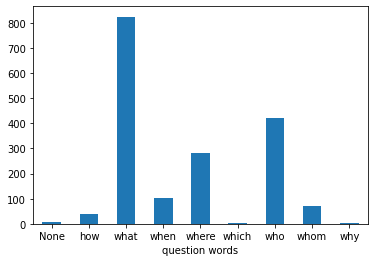

In [14]:
get_question_words_distribution(valid_df)

question words
None       14
how       112
what     2331
when      285
where     865
which      17
who      1217
whom      152
why        10
Name: Meaningful, dtype: int64


0

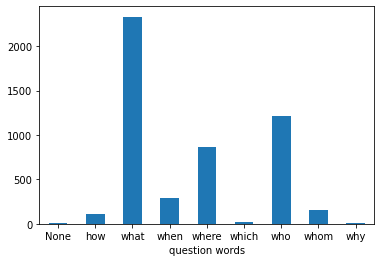

In [15]:
get_question_words_distribution(test_df)

## Counting Unique words in Qeustions

In [17]:
def get_count_of_unique_words(dataframe):
    tokenizer = lambda string:string.strip().lower().split()
    tokenized_questions = dataframe['Question'].astype(str).apply(tokenizer).to_list()
    flatten_tokenized_questions = [item for sublist in tokenized_questions for item in sublist]
    return len(set(flatten_tokenized_questions))

In [18]:
print(get_count_of_unique_words(train_df))
print(get_count_of_unique_words(valid_df))
print(get_count_of_unique_words(test_df))

10123
2958
6314


## Question length histogram

In [54]:
def get_length(dataframe):
    tokenizer = lambda string:len(string.strip().lower().split())
    dataframe['length'] = dataframe['Question'].astype(str).apply(tokenizer)
    ax = dataframe.hist(column=['length'], bins=50, grid=True)
    ax[0, 0].set_xlim(1, 16)
    return dataframe['length']
     

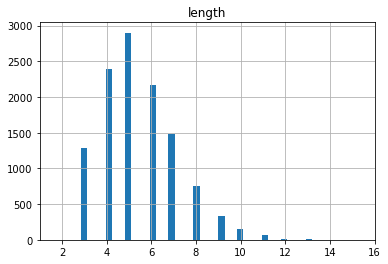

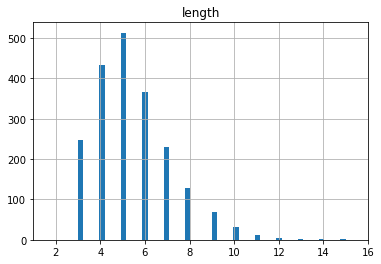

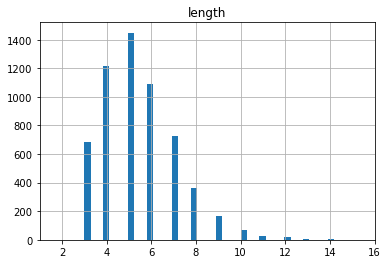

In [55]:
tr = get_length(train_df)
va = get_length(valid_df)
te = get_length(test_df)

## length of Train, Valid, Test

In [21]:
train, valid, test = read_data()
print(len(train[0]), len(valid[0]), len(test[0]))

9921 1751 5003


## Determining relation component count

In [22]:
def get_relation_component_count(dataset):
    results = []
    for item in dataset[1]:
#         print(item[2:])
        temp = ''.join(map(str, item[2:].tolist())).split('0')
        temp = list(filter(lambda item:item!='', temp))
        results.append(len(temp))
    components = []
    occurrences = []
    for item in set(results):
        components.append(str(item))
        occurrences.append(results.count(item))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(components,occurrences)
    plt.show() 
    return components,occurrences


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


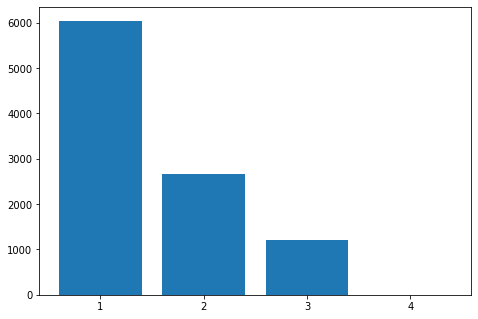

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


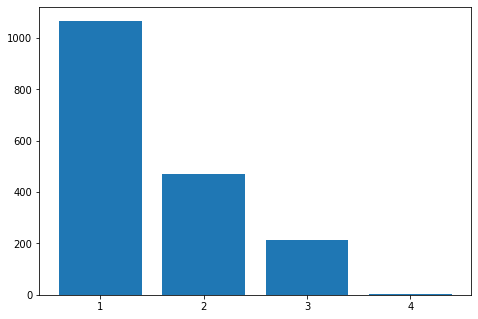

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


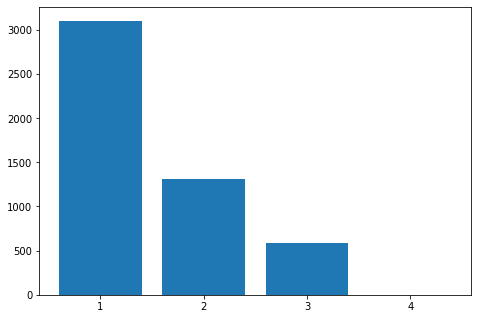

In [23]:
tr = get_relation_component_count(train)
va = get_relation_component_count(valid)
te = get_relation_component_count(test)

## Determining length of relation based on whole question length

In [24]:
def get_relation_length(dataset):
    results = []
    for tok, rel in zip(dataset[0], dataset[1]):
        length = sum((tok!=0).astype(int))
        temp = sum(rel[2:])/length
        results.append(temp)
    results = map(lambda item:round(item, 1), results)
    results = list(results)
    components = []
    occurrences = []
    for item in sorted(set(results)):
        components.append(str(item))
        occurrences.append(results.count(item))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
#     ax.set_xticks(ax.get_xticks()[::2])
    ax.bar(components,occurrences)
    plt.show() 
    return components,occurrences

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


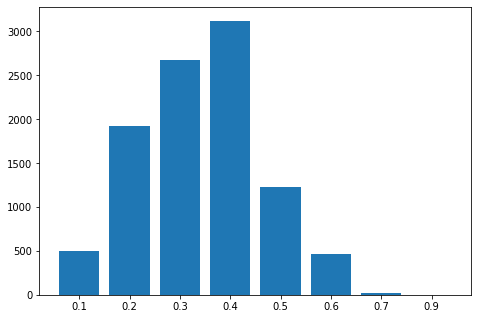

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


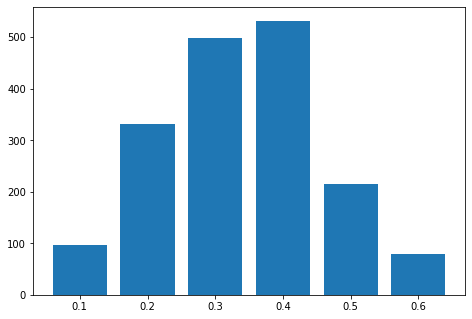

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


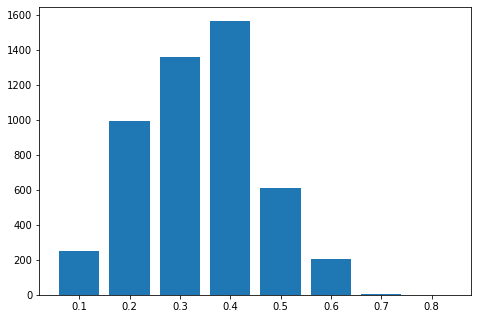

In [25]:
tr = get_relation_length(train); va = get_relation_length(valid); te = get_relation_length(test) 

In [39]:
error_dataframe = {
                    'Question':[],
                    'candidates':[],
                    'actual':[],
                    'node':[],
                    'edge':[]
                }
with open('./results/Valid_Set_With.txt', 'r') as res:
    for line in res:
        if line.find('Question')!=-1:
            temp = eval(line.split(': ')[1].strip())
            error_dataframe['Question'].append(' '.join(temp))
        elif line.find('Sorted candidates')!=-1:
            error_dataframe['candidates'].append(eval(line.split(': ')[1].strip()))
        elif line.find('Node: ')!=-1:
            line = line.replace(', Edge','').split(': ')
            error_dataframe['node'].append(line[1])
            error_dataframe['edge'].append(line[2])
        elif line.find('Actual line number')!=-1:
            error_dataframe['actual'].append(eval(line.split(': ')[1].strip()))
error_dataframe['Meaningful'] = [1 for _ in error_dataframe['actual']]
# for k,v in error_dataframe.items():
#     print(k, len(v), v[:5])
#     error_dataframe[k]=v[:5350]
error_df = pd.DataFrame(error_dataframe)            

In [40]:
def rec_rank(key,dic):
    try:
        return dic[key]/float(sum(dic.values()))
    except:
        return 1/1000
def get_mean_rec_rank(dataframe):
    dataframe['rr'] = dataframe.apply(lambda row:rec_rank(row['actual'],Counter([item[0] for item in row['candidates']])), axis=1)
    print(dataframe['rr'].mean())

In [41]:
get_mean_rec_rank(error_df)

0.46961326424482935


In [42]:
def get_was_born(string):
    tokenized = string.strip().lower().split()
    if ('was' in tokenized) and ('born' in tokenized):
            return True
    return False
error_df['was born']=error_df['Question'].apply(get_was_born)

In [43]:
get_null_candidates = lambda candidates:len(candidates)==0
null_questions = copy(error_df[error_df['candidates'].apply(get_null_candidates)])
not_null_questions = copy(error_df[~error_df['candidates'].apply(get_null_candidates)])

In [44]:
null_questions.to_excel('./results/null.xlsx')

question words
how        8
what     105
when      28
where     59
who        4
whom      18
why        1
Name: Meaningful, dtype: int64


0

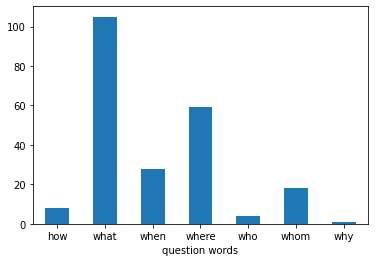

In [45]:
get_question_words_distribution(null_questions)

In [46]:
def get_all_hit1(dataframe):
    index_list = []
    for index, row in dataframe.iterrows():
        if row['candidates'][0][0]==row['actual']:
                index_list.append(True)
        else:
            index_list.append(False)
    return index_list

In [47]:
not_null_questions[get_all_hit1(not_null_questions)].to_excel('./results/hit1.xlsx')

In [48]:
not_null_questions[[not elem for elem in get_all_hit1(not_null_questions)]].to_excel('./results/not_null_not_hit1.xlsx')

## Counting Unique rels and args in Reverb tuples

In [51]:
df = pd.read_csv(r'C:\git\reverb_wikipedia_tuples-1.1.txt', sep='\t', header=None)
reverb_columns_name = ['ExID', 'arg1', 'rel', 'arg2', 'narg1', 'nrel', 'narg2', 'csents', 'conf', 'urls']
df.columns = reverb_columns_name
df = df.dropna()
df = df.drop_duplicates()


In [52]:
print(f'Unique arg1 : {len(df["arg1"].unique())}')
print(f'Unique arg2 : {len(df["arg2"].unique())}')
print(f'Unique rel : {len(df["rel"].unique())}')
print(f'Unique args : {len(set(df["arg1"].unique().tolist()+df["arg2"].unique().tolist()))}')
print(f'Unique narg1 : {len(df["narg1"].unique())}')
print(f'Unique narg2 : {len(df["narg2"].unique())}')
print(f'Unique nrel : {len(df["nrel"].unique())}')
print(f'Unique nargs : {len(set(df["narg1"].unique().tolist()+df["narg2"].unique().tolist()))}')



Unique arg1 : 182329
Unique arg2 : 156166
Unique rel : 101977
Unique args : 304853
Unique narg1 : 173067
Unique narg2 : 149581
Unique nrel : 82699
Unique nargs : 278143


In [53]:
normal_vocab = df["narg1"].unique().tolist()+df["narg2"].unique().tolist()+df["nrel"].unique().tolist()
normal_vocab = list(map(lambda x:x.split(), normal_vocab))
normal_vocab = [item for sublist in normal_vocab for item in sublist]
print(len(set(normal_vocab)))

125056


In [54]:
vocab = df["arg1"].unique().tolist()+df["arg2"].unique().tolist()+df["rel"].unique().tolist()
vocab = list(map(lambda x:x.split(), vocab))
vocab = [item for sublist in vocab for item in sublist]
print(len(set(vocab)))

148953
